Various 2-dim datasets.
Taken from https://github.com/bayesiains/nsf/blob/master/data/plane.py
Copied under MIT license (c) Conor Durkan, Artur Bekasov, Iain Murray, George Papamakarios.
Two additional datasets added (c) Samuel Klein, John Raine

In [2]:
# dataset = Anulus(num_points=int(1e6))

# data = dataset.data.numpy()
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# # ax.scatter(data[:, 0], data[:, 1], s=2, alpha=0.5)
# bound = 4
# bounds = [[-bound, bound], [-bound, bound]]
# # bounds = [
# #     [0, 1],
# #     [0, 1]
# # ]
# ax.hist2d(data[:, 0], data[:, 1], bins=256, range=bounds)
# ax.set_xlim(bounds[0])
# ax.set_ylim(bounds[1])
# plt.show()

In [3]:
import numpy as np
import os
import torch

In [4]:
from torch import distributions
from torch.utils.data import Dataset


class PlaneDataset(Dataset):
    def __init__(self, num_points, flip_axes=False):
        self.num_points = num_points
        self.flip_axes = flip_axes
        self.data = None
        self.reset()

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return self.num_points

    def reset(self):
        self._create_data()
        if self.flip_axes:
            x1 = self.data[:, 0]
            x2 = self.data[:, 1]
            self.data = torch.stack([x2, x1]).t()

    def _create_data(self):
        raise NotImplementedError


class GaussianDataset(PlaneDataset):
    def _create_data(self):
        x1 = torch.randn(self.num_points)
        x2 = 0.5 * torch.randn(self.num_points)
        self.data = torch.stack((x1, x2)).t()


class CrescentDataset(PlaneDataset):
    def _create_data(self):
        x1 = torch.randn(self.num_points)
        x2_mean = 0.5 * x1 ** 2 - 1
        x2_var = torch.exp(torch.Tensor([-2]))
        x2 = x2_mean + x2_var ** 0.5 * torch.randn(self.num_points)
        self.data = torch.stack((x2, x1)).t()


class CrescentCubedDataset(PlaneDataset):
    def _create_data(self):
        x1 = torch.randn(self.num_points)
        x2_mean = 0.2 * x1 ** 3
        x2_var = torch.ones(x1.shape)
        x2 = x2_mean + x2_var ** 0.5 * torch.randn(self.num_points)
        self.data = torch.stack((x2, x1)).t()


class SineWaveDataset(PlaneDataset):
    def _create_data(self):
        x1 = torch.randn(self.num_points)
        x2_mean = torch.sin(5 * x1)
        x2_var = torch.exp(-2 * torch.ones(x1.shape))
        x2 = x2_mean + x2_var ** 0.5 * torch.randn(self.num_points)
        self.data = torch.stack((x1, x2)).t()


class AbsDataset(PlaneDataset):
    def _create_data(self):
        x1 = torch.randn(self.num_points)
        x2_mean = torch.abs(x1) - 1.
        x2_var = torch.exp(-3 * torch.ones(x1.shape))
        x2 = x2_mean + x2_var ** 0.5 * torch.randn(self.num_points)
        self.data = torch.stack((x1, x2)).t()


class SignDataset(PlaneDataset):
    def _create_data(self):
        x1 = torch.randn(self.num_points)
        x2_mean = torch.sign(x1) + x1
        x2_var = torch.exp(-3 * torch.ones(x1.shape))
        x2 = x2_mean + x2_var ** 0.5 * torch.randn(self.num_points)
        self.data = torch.stack((x1, x2)).t()


class FourCircles(PlaneDataset):
    def __init__(self, num_points, flip_axes=False):
        if num_points % 4 != 0:
            raise ValueError('Number of data points must be a multiple of four')
        super().__init__(num_points, flip_axes)

    @staticmethod
    def create_circle(num_per_circle, std=0.1):
        u = torch.rand(num_per_circle)
        x1 = torch.cos(2 * np.pi * u)
        x2 = torch.sin(2 * np.pi * u)
        data = 2 * torch.stack((x1, x2)).t()
        data += std * torch.randn(data.shape)
        return data

    def _create_data(self):
        num_per_circle = self.num_points // 4
        centers = [
            [-1, -1],
            [-1, 1],
            [1, -1],
            [1, 1]
        ]
        self.data = torch.cat(
            [self.create_circle(num_per_circle) - torch.Tensor(center)
             for center in centers]
        )


class DiamondDataset(PlaneDataset):
    def __init__(self, num_points, flip_axes=False, width=20, bound=2.5, std=0.04):
        # original values: width=15, bound=2, std=0.05
        self.width = width
        self.bound = bound
        self.std = std
        super().__init__(num_points, flip_axes)

    def _create_data(self, rotate=True):
        # probs = (1 / self.width**2) * torch.ones(self.width**2)
        #
        # means = torch.Tensor([
        #     (x, y)
        #     for x in torch.linspace(-self.bound, self.bound, self.width)
        #     for y in torch.linspace(-self.bound, self.bound, self.width)
        # ])
        #
        # covariance = self.std**2 * torch.eye(2)
        # covariances = covariance[None, ...].repeat(self.width**2, 1, 1)
        #
        # mixture_distribution = distributions.OneHotCategorical(
        #     probs=probs
        # )
        # components_distribution = distributions.MultivariateNormal(
        #     loc=means,
        #     covariance_matrix=covariances
        # )
        #
        # mask = mixture_distribution.sample((self.num_points,))[..., None].repeat(1, 1, 2)
        # samples = components_distribution.sample((self.num_points,))
        # self.data = torch.sum(mask * samples, dim=-2)
        # if rotate:
        #     rotation_matrix = torch.Tensor([
        #         [1 / np.sqrt(2), -1 / np.sqrt(2)],
        #         [1 / np.sqrt(2), 1 / np.sqrt(2)]
        #     ])
        #     self.data = self.data @ rotation_matrix
        means = np.array([
            (x + 1e-3 * np.random.rand(), y + 1e-3 * np.random.rand())
            for x in np.linspace(-self.bound, self.bound, self.width)
            for y in np.linspace(-self.bound, self.bound, self.width)
        ])

        covariance_factor = self.std * np.eye(2)

        index = np.random.choice(range(self.width ** 2), size=self.num_points, replace=True)
        noise = np.random.randn(self.num_points, 2)
        self.data = means[index] + noise @ covariance_factor
        if rotate:
            rotation_matrix = np.array([
                [1 / np.sqrt(2), -1 / np.sqrt(2)],
                [1 / np.sqrt(2), 1 / np.sqrt(2)]
            ])
            self.data = self.data @ rotation_matrix
        self.data = self.data.astype(np.float32)
        self.data = torch.Tensor(self.data)


class TwoSpiralsDataset(PlaneDataset):
    def _create_data(self):
        n = torch.sqrt(torch.rand(self.num_points // 2)) * 540 * (2 * np.pi) / 360
        d1x = -torch.cos(n) * n + torch.rand(self.num_points // 2) * 0.5
        d1y = torch.sin(n) * n + torch.rand(self.num_points // 2) * 0.5
        x = torch.cat([torch.stack([d1x, d1y]).t(), torch.stack([-d1x, -d1y]).t()])
        self.data = x / 3 + torch.randn_like(x) * 0.1


class TestGridDataset(PlaneDataset):
    def __init__(self, num_points_per_axis, bounds):
        self.num_points_per_axis = num_points_per_axis
        self.bounds = bounds
        self.shape = [num_points_per_axis] * 2
        self.X = None
        self.Y = None
        super().__init__(num_points=num_points_per_axis ** 2)

    def _create_data(self):
        x = np.linspace(self.bounds[0][0], self.bounds[0][1], self.num_points_per_axis)
        y = np.linspace(self.bounds[1][0], self.bounds[1][1], self.num_points_per_axis)
        self.X, self.Y = np.meshgrid(x, y)
        data_ = np.vstack([self.X.flatten(), self.Y.flatten()]).T
        self.data = torch.tensor(data_).float()


class CheckerboardDataset(PlaneDataset):
    def _create_data(self):
        x1 = torch.rand(self.num_points) * 4 - 2
        x2_ = torch.rand(self.num_points) - torch.randint(0, 2, [self.num_points]).float() * 2
        x2 = x2_ + torch.floor(x1) % 2
        self.data = torch.stack([x1, x2]).t() * 2

In [5]:
from matplotlib import pyplot as plt

In [6]:
class ConcentricRings(PlaneDataset):
    def __init__(self, num_points, flip_axes=False):
        if num_points % 4 != 0:
            raise ValueError('Number of data points must be a multiple of four')
        super().__init__(num_points, flip_axes)

    @staticmethod
    def create_circle(num_per_circle, std=0.1):
        u = torch.rand(num_per_circle)
        x1 = torch.cos(2 * np.pi * u)
        x2 = torch.sin(2 * np.pi * u)
        data = 2 * torch.stack((x1, x2)).t()
        data += std * torch.randn(data.shape)
        return data

    def _create_data(self):
        num_per_circle = self.num_points // 4
        radii = [
            1.,
            2.,
            3.,
            4.
        ]
        radii = [0.4 * r for r in radii]
        self.data = torch.cat(
            [radius * self.create_circle(num_per_circle)
             for radius in radii]
        )


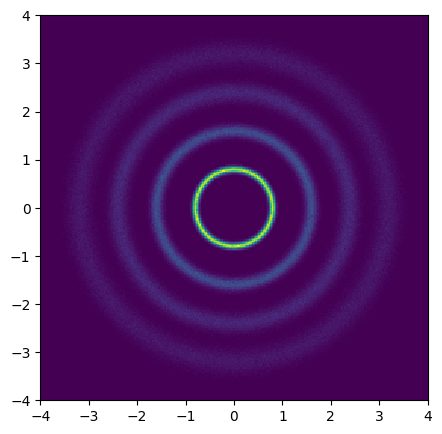

In [7]:
dataset = ConcentricRings(num_points=int(1e6))

data = dataset.data.numpy()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.scatter(data[:, 0], data[:, 1], s=2, alpha=0.5)
bound = 4
bounds = [[-bound, bound], [-bound, bound]]
# bounds = [
#     [0, 1],
#     [0, 1]
# ]
ax.hist2d(data[:, 0], data[:, 1], bins=256, range=bounds)
ax.set_xlim(bounds[0])
ax.set_ylim(bounds[1])
plt.show()

In [8]:
class Anulus(PlaneDataset):
    def __init__(self, num_points, radius=None, flip_axes=False):
        self.inner_radius = 1.0
        self.radius = radius
        super().__init__(num_points, flip_axes)

    @staticmethod
    def create_circle(num_per_circle, radius=None, std=0.1, inner_radius=0.5):
        u = torch.rand(num_per_circle)
        r = 3 * torch.rand(num_per_circle) if radius is None else radius * torch.ones(num_per_circle)
        r += inner_radius
        x1 = torch.cos(2 * np.pi * u)
        x2 = torch.sin(2 * np.pi * u)
        data = 2 * torch.stack((x1, x2)).t()
        data += std * torch.randn(data.shape)
        data = 0.5 * (r.view(-1, 1)) * data
        return data

    def _create_data(self):
        self.data = self.create_circle(self.num_points, radius=self.radius, inner_radius=self.inner_radius)


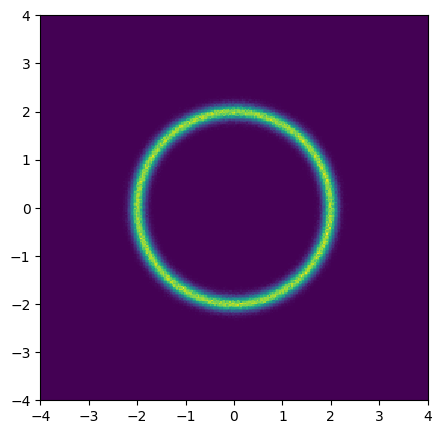

In [9]:
dataset = Anulus(num_points=int(1e6), radius=1)

data = dataset.data.numpy()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.scatter(data[:, 0], data[:, 1], s=2, alpha=0.5)
bound = 4
bounds = [[-bound, bound], [-bound, bound]]
# bounds = [
#     [0, 1],
#     [0, 1]
# ]
ax.hist2d(data[:, 0], data[:, 1], bins=256, range=bounds)
ax.set_xlim(bounds[0])
ax.set_ylim(bounds[1])
plt.show()

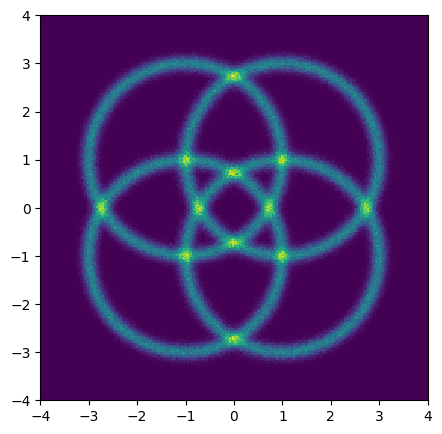

In [10]:
dataset = FourCircles(num_points=int(1e6))

data = dataset.data.numpy()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.scatter(data[:, 0], data[:, 1], s=2, alpha=0.5)
bound = 4
bounds = [[-bound, bound], [-bound, bound]]
# bounds = [
#     [0, 1],
#     [0, 1]
# ]
ax.hist2d(data[:, 0], data[:, 1], bins=256, range=bounds)
ax.set_xlim(bounds[0])
ax.set_ylim(bounds[1])
plt.show()

In [ ]:
class Star(PlaneDataset):
    def __init__(self, num_points, num_bars=4, flip_axes=False):
        if num_points % num_bars != 0:
            raise ValueError('Number of data points must be a multiple of four')
        self.num_bars = num_bars
        super().__init__(num_points, flip_axes)

    @staticmethod
    def create_bar(num_per_bar, angle, std=0.1):
        u = torch.rand(num_per_bar)
        x1 = u+0.3
        x2 = torch.zeros_like(u)
        data = 2 * torch.stack((x1, x2)).t()
        data += std * torch.randn(data.shape)
        # x1 = torch.cos(2 * np.pi * u)
        # x2 = torch.sin(2 * np.pi * u)
        return data
    
    @staticmethod
    def rotate(x,theta):
        rot_mat = torch.Tensor([[np.cos(theta),np.sin(theta)],
                        [-np.sin(theta), np.cos(theta)]])
        return torch.matmul(x,theta)

    def _create_data(self):
        num_per_bar = self.num_points // self.num_bars
        angles = np.linspace(0,1,self.num_bars+1)[:-1]*2*np.pi
        self.data = torch.cat(
            [self.rotate(self.create_bar(num_per_bar),theta)
             for theta in angles]
        )

In [31]:
u = torch.rand(int(1e4))
x1 = u+0.3
x2 = torch.zeros_like(u)
data = 2 * torch.stack((x1, x2)).t()
data += 0.1 * torch.randn(data.shape)

In [40]:
rot_mat = torch.Tensor([[np.cos(theta),np.sin(theta)],
                        [-np.sin(theta), np.cos(theta)]])

In [41]:
rot_mat

tensor([[-1.8370e-16, -1.0000e+00],
        [ 1.0000e+00, -1.8370e-16]])

In [47]:
torch.matmul(data,rot_mat)

tensor([[ 0.0591, -1.1681],
        [ 0.0532, -2.6106],
        [ 0.1907, -1.6589],
        ...,
        [ 0.1487, -2.2175],
        [-0.0869, -0.9562],
        [-0.1108, -1.8836]])

In [50]:
np.linspace(0,1,4+1)[:-1]

array([0.  , 0.25, 0.5 , 0.75])